In [33]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import transport_qmc.targets as Targets
from transport_qmc.tqmc import TransportQMC
from transport_qmc.train import lbfgs
from transport_qmc.utils import sample_uniform

### Set up the target distribution

In [34]:
posterior_name = 'nes_logit'
data_file = f"stan/{posterior_name}.json"
target = getattr(Targets, posterior_name)(data_file)
d = target.d
print("Dimension =", d)

Dimension = 2


### Set up normalizing flow

In [35]:
model = TransportQMC(d, target, num_composition=1, max_deg=7)
params = model.init_params()

get_kl = jax.jit(model.reverse_kl)  # use reverse KL as loss function
get_ess = jax.jit(model.ess) # use ESS as validation metric


In [36]:
rng = np.random.default_rng(1)
nsample = 2**8

U_train = jnp.array(sample_uniform(nsample, d, rng, 'rqmc'))
loss_fn = lambda params: get_kl(params, U_train)

U_val = jnp.array(sample_uniform(nsample, d, rng, 'rqmc')) 
val_fn = lambda params: get_ess(params, U_val)

### Training normalizing flow

In [39]:
final_state, ess_trace = lbfgs(loss_fn, params, val_fn, max_iter=100, max_lr=1.)

Running for 100 iterations: 100%|██████████| 100/100 [00:05<00:00, 18.74it/s]


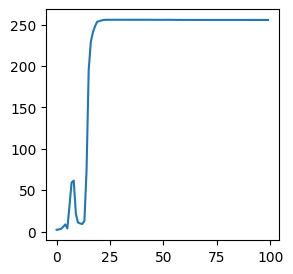

In [40]:
# plot ESS versus iterations
plt.figure(figsize=(3, 3))
plt.plot(ess_trace)

### Generate samples from the trained flow

In [41]:
params = final_state[0]
nf_samples, log_weights = model.sample(params, 2**10, 10)

In [42]:
weights = jnp.exp(log_weights - jnp.max(log_weights))
moments_1 = jnp.sum(weights[:, None] * nf_samples, axis=0) / jnp.sum(weights)
moments_2 = jnp.sum(weights[:, None] * nf_samples**2, axis=0) / jnp.sum(weights)

In [43]:
moments_1, moments_2

(Array([-1.3544537,  0.3121986], dtype=float32),
 Array([1.8688005 , 0.10057709], dtype=float32))

### Compare with MCMC

In [45]:
from numpyro.infer import NUTS, MCMC

nuts_kernel = NUTS(target.numpyro_model)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=1000)
mcmc.run(jax.random.key(1))

mcmc_samples = mcmc.get_samples()

sample: 100%|██████████| 1100/1100 [00:00<00:00, 1140.62it/s, 3 steps of size 2.33e-01. acc. prob=0.88]


In [46]:
mcmc_samples = np.hstack([mcmc_samples['alpha'].reshape(-1, 1), mcmc_samples['beta']])
mcmc_samples = target.param_constrain(mcmc_samples)

In [47]:
np.mean(mcmc_samples, 0), np.mean(mcmc_samples**2, 0)

(array([-1.3686001 ,  0.31600034], dtype=float32),
 array([1.9159741 , 0.10376722], dtype=float32))

### Histogram of samples

(array([0.10500808, 0.36752828, 1.4701131 , 3.80654285, 6.48424886,
        6.87802915, 4.69911152, 2.25767369, 0.68255251, 0.1312601 ]),
 array([0.11977645, 0.15697597, 0.19417549, 0.23137501, 0.26857453,
        0.30577404, 0.34297356, 0.38017308, 0.4173726 , 0.45457212,
        0.49177164]),
 <BarContainer object of 10 artists>)

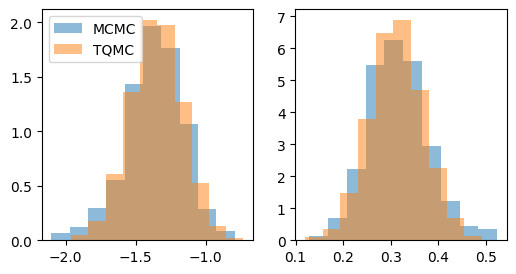

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].hist(mcmc_samples[:, 0], alpha=0.5, density=True, label='MCMC')
ax[0].hist(nf_samples[:, 0], alpha=0.5, density=True, label='TQMC')
ax[0].legend()

ax[1].hist(mcmc_samples[:, 1], alpha=0.5, density=True)
ax[1].hist(nf_samples[:, 1], alpha=0.5, density=True)